# Real or Not? NLP with Disaster Tweets

This is an introductory Kaggle competition for using NLP to predict whether a tweet is about an actual disaster or not. It is a binary classification task using the F1 score as the evaluation metric.

In [1]:
# Import required packages
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
np.random.seed(27)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']   
%matplotlib inline
import seaborn as sns
sns.color_palette('muted')
current_palette = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

import re

from mlxtend.plotting import plot_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb


In [2]:
# Import data - first two lines of code are for Kaggle submission. Second two are for local.
# train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
# test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_df = train.copy()
test_df = test.copy()

In [3]:
train_df.sample(10)

,id,keyword,location,text,target
2111,3034,death,NaN,New crime: knowing your rights. Punishable by death,0
1731,2494,collided,NaN,It's Even Worse Than It Looks: How the American Constitutional System Collided With the New PoliticÛ_ http://t.co/Gfa3SOw9zn,0
987,1432,body%20bagging,ATL ? SEA,Drake is really body bagging meek,0
1216,1754,buildings%20burning,Selma2Oakland,People are more worried about the burning of buildings than black people losing their lives disgusting.,1
1127,1625,bombed,"Ikeja, Nigeria",70 years ago today the United States of America bombed Hiroshima in Japan.,1
4613,6556,injury,Los Angeles,Dr Jack Stern Interview Ending Back Pain for #Military #Injury. Listen now: http://t.co/YhH7X0MAio,0
2011,2887,damage,NaN,@WonderousAllure crosses her arms to cover her hands from doing anymore damage. 'H-Hello..',0
4539,6453,injured,Worldwide,Top Stories - Google 4 dead dozens injured in Gaza blast near house leveled in summer warÛ_ http://t.co/P3o71DZ992,1
4132,5875,hailstorm,far away,Calgary news weather and traffic for August 5 * ~ 45 http://t.co/zAGBMlSf4H http://t.co/HVYXehXBmq,0
702,1010,blazing,Suitland,@OfficialTJonez Your 'Lost For Words' made me a new fan of yours fam. Crazy skills beyond blessed! Keep blazing dude made love and respect!,0


In [4]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

In [5]:
print("Training Set\n")
print(f"The keyword feature contains {round(train_df['keyword'].isna().sum()/len(train_df),2)*100}% null values")
print(f"The location feature contains {round(train_df['location'].isna().sum()/len(train_df),2)*100}% null values\n")

print("Test Set\n")
print(f"The keyword feature contains {round(test_df['keyword'].isna().sum()/len(test_df),2)*100}% null values")
print(f"The location feature contains {round(test_df['location'].isna().sum()/len(test_df),2)*100}% null values\n")

Training Set

The keyword feature contains 1.0% null values
The location feature contains 33.0% null values

Test Set

The keyword feature contains 1.0% null values
The location feature contains 34.0% null values



The initial examination of the data shows each set has four features (counting the id but not counting the target). There are 7613 entries in the training set and 3263 in the test set.

In both cases around 1% of the keyword feature is null and a third of the location feature is null.

The missing keyword and location data could be left null, though it may be possible to impute some of the missing data should it seem beneficial.

Some initial preprocessing, e.g. converting the text all to lower case and removing stop words and punctuation will improve later text analysis. However, as the dataframe is not too large and each main text entry limited to tweet length, I will retain the original form as the presence of some punctuation features may be useful.

In [6]:
# Write function to add a cleaned text feature to a dataframe and also replace %20 with a space in the keyword feature
def clean_text(df):
    df = df.copy(deep=True)
    df['cleaned_text'] = df['text'].apply(lambda x: x.lower())
    df['cleaned_text'].apply(lambda x: [word for word in x if word not in stop])
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"@[\S]+","",x)) #remove twitter handles
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"http[\S]+","",x)) # remove web addresses
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"\n"," ",x)) # remove line breaks
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"-"," ",x)) # replace dashes with spaces
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]","",x)) 
    
    df['keyword'] = df['keyword'].apply(lambda x: str(x).lower())
    df['keyword'] = df['keyword'].apply(lambda x: str(x).replace("%20"," "))
    df['keyword'] = df['keyword'].replace('nan',np.NaN)
    
    df['location'] = df['location'].apply(lambda x: str(x).lower())
    df['location'] = df['location'].replace('nan',np.NaN)
        
    return df

In [7]:
train_df = clean_text(train_df)
test_df = clean_text(test_df)

train_df.sample(5)

,id,keyword,location,text,target,cleaned_text
6528,9338,survive,death star,If I survive I'll see you tomorrow,0,if i survive ill see you tomorrow
3613,5157,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1,11 year old boy charged with manslaughter of toddler report an 11 year old boy has been charged with manslaughter over the fatal sh
4459,6342,hostages,midwest,Sinjar Massacre Yazidis Blast Lack of Action OveråÊHostages http://t.co/Carvv6gsRb http://t.co/lAn76ZqKxG,1,sinjar massacre yazidis blast lack of action overhostages
7471,10688,wreck,1/10 taron squad,Season 3 of New Girl was such a emotional train wreck I just wanted to cry laugh and eat a lot of ice cream,0,season 3 of new girl was such a emotional train wreck i just wanted to cry laugh and eat a lot of ice cream
1334,1927,burning buildings,we?it û¢ ixwin,@Louis_Tomlinson incredible? THE CHILDREN WERE SCREAMING BUILDINGS WERE BURNING AND I WAS DANCING IN THE ASHES,1,incredible the children were screaming buildings were burning and i was dancing in the ashes


## EDA
### Initial Hypotheses

Some intitial ideas for areas to investigate are:
- Does having a location make the tweet more likely to be real
- Is the number of characters in a tweet significant
- Can punctuation, specifically the presence of exclamation marks, tell us anything
- Does whether or not a tweet is directed @ someone have an impact
- Does the tweet contain a web address

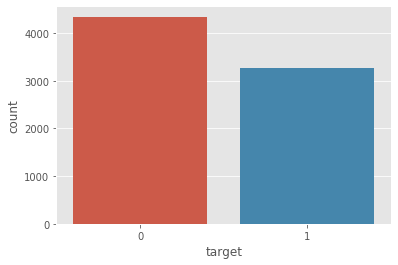

In [8]:
# Look at ratio of True to False tweets in the training set
_ = sns.countplot(x='target',data=train_df)

##### Location

Look at whether there are any differences between the location entries between tweets that were True and False

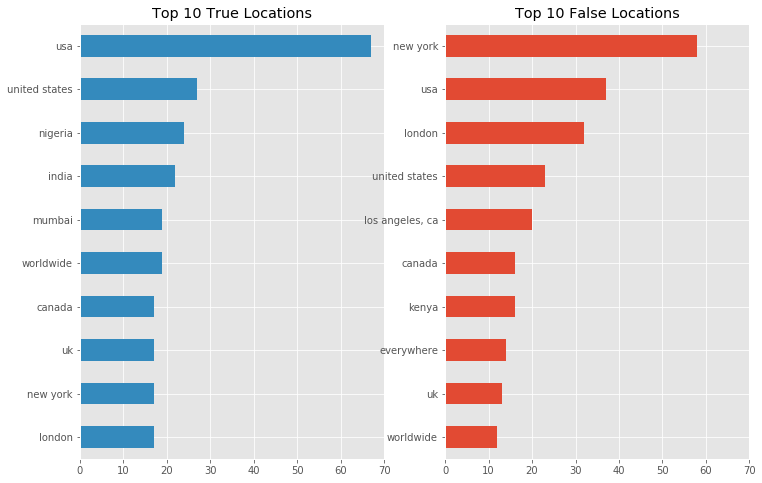

In [9]:
true_locations = train_df['location'][train_df['target']==1].value_counts().head(10)
false_locations = train_df['location'][train_df['target']==0].value_counts().head(10)

fig, ax= plt.subplots(1,2,figsize=(12,8))
_ = true_locations.sort_values().plot.barh(ax=ax[0],title='Top 10 True Locations',color=colours[1],xlim=[0,70])
_ = false_locations.sort_values().plot.barh(ax=ax[1],title='Top 10 False Locations',xlim=[0,70])

In [10]:
missing_locations_true = round(train_df['location'][train_df['target']==1].isna().sum()\
                               /len(train_df[train_df['target']==1])*100,2)
missing_locations_false = round(train_df['location'][train_df['target']==0].isna().sum()\
                               /len(train_df[train_df['target']==0])*100,2)

print(f"""True tweets have {missing_locations_true}% of locations missing\n
False tweets have {missing_locations_false}% of locations missing""")

True tweets have 32.86% of locations missing

False tweets have 33.58% of locations missing


##### Keyword

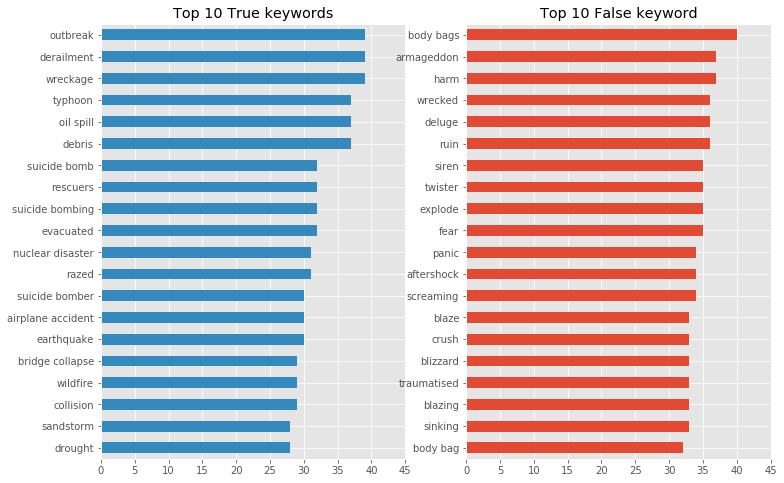

In [11]:
true_keywords = train_df['keyword'][train_df['target']==1].value_counts().head(20)
false_keywords = train_df['keyword'][train_df['target']==0].value_counts().head(20)

fig, ax = plt.subplots(1,2,figsize=(12,8))
_ = true_keywords.sort_values().plot.barh(ax=ax[0],title='Top 10 True keywords',color=colours[1],xlim=[0,45])
_ = false_keywords.sort_values().plot.barh(ax=ax[1],title='Top 10 False keyword',xlim=[0,45])

There are a number of two word entries, it may be beneficial to simplify these by just taking the first word in all cases.

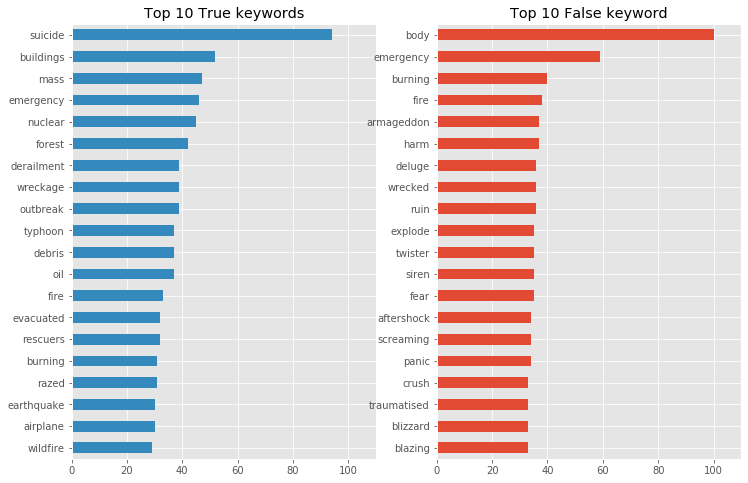

In [12]:
single_word_train = train_df['keyword'].apply(lambda x: str(x).split(" ")[0])
single_word_train = single_word_train.replace('nan',np.NaN) # .split on an empty string returns nan

true_keywords = single_word_train[train_df['target']==1].value_counts().head(20)
false_keywords = single_word_train[train_df['target']==0].value_counts().head(20)

fig, ax = plt.subplots(1,2,figsize=(12,8))
_ = true_keywords.sort_values().plot.barh(ax=ax[0],title='Top 10 True keywords',color=colours[1],xlim=[0,110])
_ = false_keywords.sort_values().plot.barh(ax=ax[1],title='Top 10 False keyword',xlim=[0,110])

In [13]:
true_keywords_set = set(true_keywords.index)
false_keywords_set = set(false_keywords.index)

true_keywords_set.intersection(false_keywords_set)

{'burning', 'emergency', 'fire'}

The top 20 keywords appearing in True and False texts only contain three of the same words. The presence of one of the other 17 words for each case could be a useful binary feature.

##### Text
###### Number of characters in a tweet

In [14]:
true_df = train_df[train_df['target']==1]
false_df = train_df[train_df['target']==0]

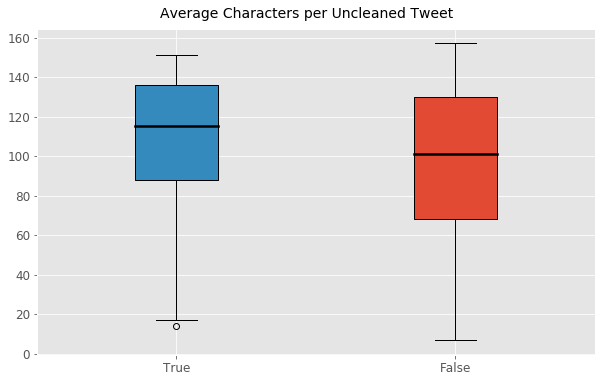


True uncleaned tweets have on average 13.0% more characters



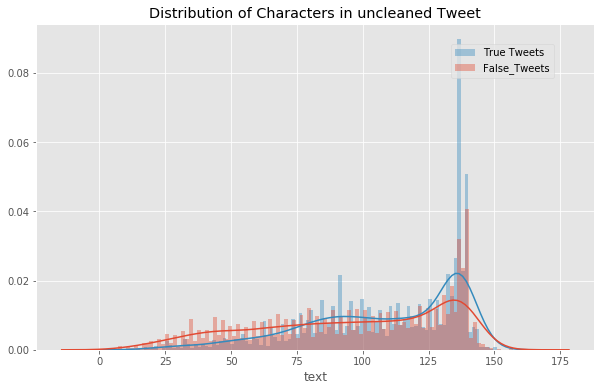

In [15]:
# Average number of characters in an uncleaned tweet, true vs False
true_text_chars = true_df['text'].apply(lambda x: len(x))
false_text_chars = false_df['text'].apply(lambda x: len(x))

fig = plt.figure(figsize = (10,6))
plt.xlim(0.25,1.25)
medianprops = dict(linewidth=2.5, color='black')
ax = plt.boxplot([true_text_chars,false_text_chars],positions=[0.5,1],labels=['True','False'],\
                 patch_artist=True,medianprops=medianprops)
plt.tick_params(axis='both', which='major', labelsize=12)
fig.suptitle('Average Characters per Uncleaned Tweet',fontsize='14',y=0.93)
colors = [colours[1], colours[0]]
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

print(f'''\nTrue uncleaned tweets have on average {round((np.mean(true_text_chars)/np.mean(false_text_chars)-1)*100,0)}\
% more characters\n''')

fig = plt.figure(figsize=(10,6))
_ = sns.distplot(true_text_chars, bins = 100,color=current_palette[1])\
.set_title('Distribution of Characters in uncleaned Tweet')
_ = sns.distplot(false_text_chars,bins=100)
_ = fig.legend(['True Tweets','False_Tweets'],loc=(0.75,0.8))

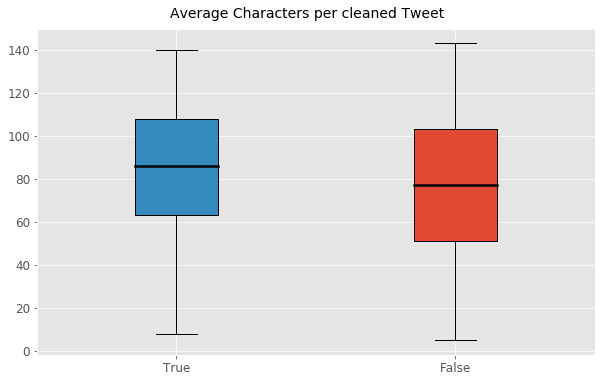


True tweets have on average 11.0% more characters



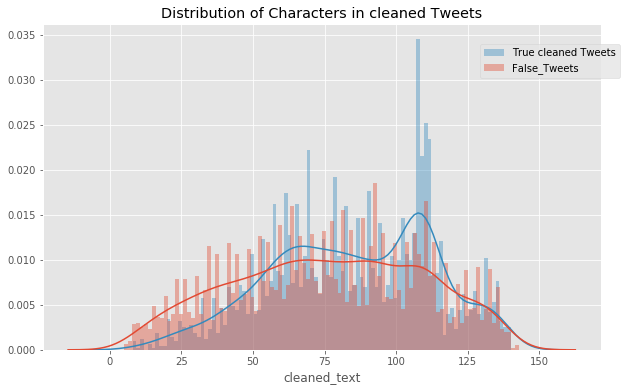

In [16]:
# Average number of characters in an cleaned tweet, true vs False
true_text_chars = true_df['cleaned_text'].apply(lambda x: len(x))
false_text_chars = false_df['cleaned_text'].apply(lambda x: len(x))

fig = plt.figure(figsize = (10,6))
plt.xlim(0.25,1.25)
medianprops = dict(linewidth=2.5, color='black')
ax = plt.boxplot([true_text_chars,false_text_chars],positions=[0.5,1],labels=['True','False'],\
                 patch_artist=True,medianprops=medianprops)
plt.tick_params(axis='both', which='major', labelsize=12)
fig.suptitle('Average Characters per cleaned Tweet',fontsize='14',y=0.93)
colors = [colours[1], colours[0]]
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

print(f'''\nTrue tweets have on average {round((np.mean(true_text_chars)/np.mean(false_text_chars)-1)*100,0)}\
% more characters\n''')

fig = plt.figure(figsize=(10,6))
_ = sns.distplot(true_text_chars, bins = 100,color=current_palette[1])\
        .set_title('Distribution of Characters in cleaned Tweets')
_ = sns.distplot(false_text_chars,bins=100)
_ = fig.legend(['True cleaned Tweets','False_Tweets'],loc=(0.75,0.8))

There is a bigger difference in tweet length in the uncleaned data. Purely looking at the tweet length might not be the best approach, creating one feature for tweets less than 75 characters long and another for tweets between 125 and 145 characters looks more promising.

###### Presence of "@"

In [17]:
# Create columns for if a tweet starts with "@" and for if it contains an "@" at all

train_df['starts_with_at'] = train_df['text'].apply(lambda x: np.where(x.startswith('@'),1,0))
train_df['not_start_at'] = train_df['text'].apply(lambda x: np.where(x.find('@')>0,1,0))
train_df['contains_at'] = train_df['text'].apply(lambda x: np.where(x.find('@')>-1,1,0))

In [18]:
at_analysis = train_df.groupby('target').agg({'starts_with_at':np.mean,'not_start_at':np.mean,'contains_at':np.mean})

at_analysis.T

target,0,1
starts_with_at,0.216260,0.124732
not_start_at,0.097651,0.081932
contains_at,0.313911,0.206665


If a tweet starts with an '@' it is over 70% more likely to be False than True whereas if a Tweet contains an '@' it is over 55% more likely to be True, but this is applicable to more Tweets. Although the contains feature would have a larger applicable span the majority of the predictive power comes from if the Tweet starts with the '@' symbol so I will use this feature.

In [19]:
train_df['contains_exclamation'] = train_df['text'].apply(lambda x: np.where(x.find('!')>0,1,0))

exclamation_analysis = train_df.groupby('target').agg({'contains_exclamation':np.mean})

exclamation_analysis.T

target,0,1
contains_exclamation,0.120451,0.059615


If a Tweet contains an exclamation mark it is more than twice as likely to be False, although only a low percenage of all tweets contain an !

## Data Processing
Having finished the first phase of EDA I will now move on to using machine learning to extract useful information from the text data and then to generate some models. As part of this process I will split the training set into training and validation sets. Before this I will process the training and test sets so that they contain the useful information fields identified above.

I will also apply th clean_text function defined earlier.

- Create a cleaned text field
- Create a binary indicator for whether a Tweet contains one of the top 17 keywords that are not shared by True and False Tweets
- Create binary indicators for whether an uncleaned Tweet has < 75 characters of between 125 and 145 characters
- Create a binary indicator for whether a Tweet starts with '@'
- Create a binary indicator for wether a Tweet contains an '!'

In [20]:
# Use previously generate list of keywords to generate which of the top 20 are unique to the True and False conditions
true_top_20_keywords = true_keywords_set - true_keywords_set.intersection(false_keywords_set)
false_top_20_keywords = false_keywords_set - true_keywords_set.intersection(false_keywords_set)

def add_eda_features(df):
    df = df.copy(deep=True) # Create copy of passed data frame to manipulate
    
    df['keyword'] = df['keyword'].replace(np.NaN,'nan') # remove any numerical NaNs for next step
    df['true_top_20_keyword'] = df['keyword'].apply(lambda x:\
                                                np.where(any([word in x for word in true_top_20_keywords])==True,1,0))
    df['false_top_20_keyword'] = df['keyword'].apply(lambda x:\
                                                np.where(any([word in x for word in false_top_20_keywords])==True,1,0))
    df['less_than_75c'] = df['text'].apply(lambda x: np.where(len(x)<75,1,0))
    df['125c_to_145c'] = df['text'].apply(lambda x: np.where(125<=len(x)<=145,1,0))
    df['starts_with_at'] = df['text'].apply(lambda x: np.where(x.startswith('@'),1,0))
    df['contains_exclamation'] = df['text'].apply(lambda x: np.where(x.find('!')>0,1,0))
    
    return df
    

In [21]:
train_df = add_eda_features(clean_text(train))
test_df = add_eda_features(clean_text(test))

In [22]:
train_df.sample(1)

,id,keyword,location,text,target,cleaned_text,true_top_20_keyword,false_top_20_keyword,less_than_75c,125c_to_145c,starts_with_at,contains_exclamation
4219,5992,hazardous,united states,JAX issues Hazardous Weather Outlook (HWO) http://t.co/u9fCb8dz3h #WX,1,jax issues hazardous weather outlook hwo wx,0,0,1,0,0,0


## Tokenization

To extract ML compatible features from the tweet content it must be processed into a numerical form, but first the data will be split into a training and validation set to allow for tuning of hyperameters.

In [23]:
# Split data - as True/False split is quite even there is no need to stratify the split

X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('target',axis=1),train_df['target']\
                                                      , test_size = 0.2, random_state = 27)

###### Vectorize Text

Use CountVectorizer and TfidfVectorizer to analyse the text of the tweets so the one which yields the best performance can be used in the final models. In both cases I will work on the cleaned text field.

The output will be in sparse matrix form.

In [24]:
# Count Vectorize
count_vectorizer = CountVectorizer()
text_counts = count_vectorizer.fit_transform(X_train['cleaned_text'])

In [25]:
# Tfidf Vectorize
tfidf_vectorizer = TfidfVectorizer()
text_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_text'])

The vetorized text outputs are in sparse form but from the earlier analysis there are some features which may be useful that are in dense form. Combining these as is will lead to the dense features dominating. To combine the two pathways I will build an initial model on the vectorized texts and use the predicted probability of one or both of these as a dense feature to combine with the other dense features for a second model. In this approach it will be important to use cross-validation predicted probabilities in order to avoid over fitting.

## Model building
To set a baseline I will build a random guess model which any ML model must perform better than. I will also construct basic models using each of the vectorized features and the dense feature set.

In [26]:
# Create baseline model of random guesses
random_pred = np.random.randint(0,2,(len(y_train),1))
f1_rand = f1_score(random_pred,y_train)
print(f'Random guessing generates an f1 score of {round(f1_rand,2)}')

Random guessing generates an f1 score of 0.45


In [27]:
# Initiate basic models
svc = SVC(kernel='rbf')
logreg = LogisticRegression()
dctree = DecisionTreeClassifier()
rforest = RandomForestClassifier()
nbayes = MultinomialNB()
xgbc = xgb.XGBClassifier(objective = 'binary:logistic')

models = [('Support Vector',svc),('Logistic Regression',logreg),('Decision Tree',dctree),('Random Forest',rforest),\
          ('Naive Bayes',nbayes),('XGBoost',xgbc)]

In [28]:
# Test basic models on just count vectorized data.
for name, model in models:
    cv = cross_val_score(model,text_counts[:2000],y_train[:2000],scoring='f1')
    print(f'The {name} classifier generates a mean f1 score of {round(cv.mean(),2)}')

The Support Vector classifier generates a mean f1 score of 0.66
The Logistic Regression classifier generates a mean f1 score of 0.71
The Decision Tree classifier generates a mean f1 score of 0.61
The Random Forest classifier generates a mean f1 score of 0.64
The Naive Bayes classifier generates a mean f1 score of 0.72
The XGBoost classifier generates a mean f1 score of 0.6


In [29]:
# Test basic models on just tfidf vectorized data.
for name, model in models:
    cv = cross_val_score(model,text_tfidf[:2000],y_train[:2000],scoring='f1')
    print(f'Using tfidf {name} classifier generates a mean f1 score of {round(cv.mean(),2)}')

Using tfidf Support Vector classifier generates a mean f1 score of 0.65
Using tfidf Logistic Regression classifier generates a mean f1 score of 0.67
Using tfidf Decision Tree classifier generates a mean f1 score of 0.59
Using tfidf Random Forest classifier generates a mean f1 score of 0.61
Using tfidf Naive Bayes classifier generates a mean f1 score of 0.66
Using tfidf XGBoost classifier generates a mean f1 score of 0.59


In [30]:
# Test dense features
dense_features = ['true_top_20_keyword','false_top_20_keyword','less_than_75c','125c_to_145c','starts_with_at',\
                 'contains_exclamation']

for name, model in models:
    cv = cross_val_score(model, X_train[dense_features][:2000],y_train.iloc[:2000],scoring = 'f1')
    print(f'Using dense features {name} classifier generates a mean f1 score of {round(cv.mean(),2)}')

Using dense features Support Vector classifier generates a mean f1 score of 0.54
Using dense features Logistic Regression classifier generates a mean f1 score of 0.46
Using dense features Decision Tree classifier generates a mean f1 score of 0.53
Using dense features Random Forest classifier generates a mean f1 score of 0.53
Using dense features Naive Bayes classifier generates a mean f1 score of 0.54
Using dense features XGBoost classifier generates a mean f1 score of 0.54


Of the models trained on the vectorized text data naive bayes and logistic regression work the best across the two vectors. On the dense data all models are comparable, though with significantly worse performance than the text vectors, except for logistic regression. I will now look at combining the outputs of the text vector models whether there is benefit to combining the text vectors and dense features.

In [31]:
countNB = MultinomialNB()
tfidfNB = MultinomialNB()
countLogReg = LogisticRegression()
tfidfLogReg = LogisticRegression()
count_models = [('Count Vectorizer Naive Bayes', countNB), ('Count Vectorizer Logistic Regression',countLogReg)]
tfidf_models = [('Tfidf Naive Bayes',tfidfNB),('Tfidf Logistic Regression',tfidfLogReg)]

In [32]:
countNB.fit(text_counts,y_train)
tfidfNB.fit(text_tfidf,y_train)
countLogReg.fit(text_counts,y_train)
tfidfLogReg.fit(text_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
for name,model in count_models:
    count_cv = cross_val_predict(model,text_counts,y_train,cv=5,method='predict_proba')
    count_score = cross_val_score(model,text_counts,y_train,scoring='f1')
    print(f'The {name} scores {round(count_score.mean(),2)}')

The Count Vectorizer Naive Bayes scores 0.75
The Count Vectorizer Logistic Regression scores 0.75


In [34]:
for name,model in tfidf_models:
    tfidf_cv = cross_val_predict(model,text_tfidf,y_train,cv=5,method='predict_proba')
    tfidf_score = cross_val_score(model,text_tfidf,y_train,scoring='f1')
    print(f'The {name} scores {round(tfidf_score.mean(),2)}')

The Tfidf Naive Bayes scores 0.72
The Tfidf Logistic Regression scores 0.74


In [35]:
combined = (count_cv[:,0] + tfidf_cv[:,0])/2
combined_preds = np.where(combined<0.5,1,0)
combined_preds[:10]

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [36]:
f1_combined = f1_score(combined_preds,y_train)
round(f1_combined,2)

0.75

Combining the predictions in this way does not improve the performance of the model compared to using the counts and tfidf individually. I will now try adding the predictions of the Naive Bayes model trained on the count vectorized data as a dense feature to the dataframe.

In [37]:
X_train['Count_Predictions'] = count_cv[:,1]
X_train.head(1)

,id,keyword,location,text,cleaned_text,true_top_20_keyword,false_top_20_keyword,less_than_75c,125c_to_145c,starts_with_at,contains_exclamation,Count_Predictions
4717,6707,lava,"santa maria, ca",Neighbor kids stopped to watch me play Disney's I Lava You song on my uke. Left as I got into Journey's Don't Stop Believing #kidsthesedays,neighbor kids stopped to watch me play disneys i lava you song on my uke left as i got into journeys dont stop believing kidsthesedays,0,0,0,1,0,0,0.013543


In [39]:
dense_features_preds = dense_features+['Count_Predictions']
fullNB = MultinomialNB()
fullNB.fit(X_train[dense_features],y_train)
full_cv = cross_val_score(fullNB,X_train[dense_features_preds],y_train,cv=10,scoring='f1')
print(f'The untuned Naive Bayes model scores {round(full_cv.mean(),2)} on the training set')

The untuned Naive Bayes model scores 0.71 on the training set


Adding in the created features actually lowers the accuracy. I will now try producing a tuned naive bayes model using only the count vectorized data.

In [42]:
text_counts_valid = count_vectorizer.transform(X_valid['cleaned_text'])
mnb = MultinomialNB()

parameters = {  
'alpha': (1, 0.9,0.8,0.7)  
}  
grid_search= GridSearchCV(mnb, parameters)
grid_search.fit(text_counts_valid,y_valid)
grid_search.best_params_

{'alpha': 0.8}

In [53]:
full_text_counts = count_vectorizer.fit_transform(train_df['cleaned_text'])

In [55]:
final_nb = MultinomialNB(alpha = 0.8)
final_nb.fit(full_text_counts,train_df['target'])

MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)

In [57]:
test_cleaned_text = count_vectorizer.transform(test_df['cleaned_text'])

In [58]:
preds = final_nb.predict(test_cleaned_text)

In [61]:
submission = pd.DataFrame({'Id':test_df['id'],'Prediction':preds})

In [63]:
submission.to_csv('submission.csv',index=False)